# TCGA Inference Demo

Predict cancer regions on H&E images from [The Cancer Genome Atlas](https://www.cancer.gov/about-nci/organization/ccg/research/structural-genomics/tcga) using a Neural Network pretrained on colorectal cancer using [HEMnet](https://github.com/BiomedicalMachineLearning/HEMnet)

> This demo runs completely in your browser

To run the code, click the play icon in the left gutter of each cell or type Cmd/Ctrl+Enter to run the cell in place. 



## Setup

Download the HEMnet Github Repository

In [1]:
!git clone https://github.com/BiomedicalMachineLearning/HEMnet.git

fatal: destination path 'HEMnet' already exists and is not an empty directory.


Install software packages

In [2]:
# Install openslide to open Whole Slide Images (WSIs)
!apt update && apt install -y openslide-tools
!pip install openslide-python

# Install SimpleITK for image registration - necessary for HEMnet package but not specifically for this Demo
!pip install SimpleITK

# Install Staintools for stain normalisation of H&E histopathology slides
!pip install spams    # Staintools dependency
!pip install staintools

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Fetched 252 kB in 2s (168 kB/s)
Reading package lists... Done
Building dependency tree       
Readin

## Load Data from TCGA

Install GDC-client so that we can download slides from TCGA


In [ ]:
!wget https://gdc.cancer.gov/files/public/file/gdc-client_v1.6.0_Ubuntu_x64-py3.7_0.zip
!unzip -o gdc-client_v1.6.0_Ubuntu_x64-py3.7_0.zip
# Add gdc-client to path
!cp -pi ./gdc-client /usr/local/bin

--2020-11-26 04:36:05--  https://gdc.cancer.gov/files/public/file/gdc-client_v1.6.0_Ubuntu_x64-py3.7_0.zip
Resolving gdc.cancer.gov (gdc.cancer.gov)... 192.170.230.224, 2605:9a00:10:4008::101
Connecting to gdc.cancer.gov (gdc.cancer.gov)|192.170.230.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19603683 (19M) [application/zip]
Saving to: ‘gdc-client_v1.6.0_Ubuntu_x64-py3.7_0.zip.1’

gdc-client_v1.6.0_U 100%[===================>]  18.70M  4.40MB/s    in 6.1s    

2020-11-26 04:36:12 (3.05 MB/s) - ‘gdc-client_v1.6.0_Ubuntu_x64-py3.7_0.zip.1’ saved [19603683/19603683]

Archive:  gdc-client_v1.6.0_Ubuntu_x64-py3.7_0.zip
  inflating: gdc-client              
cp: overwrite '/usr/local/bin/gdc-client'? 

Download an example slide - as specified in a manifest file

> If you would like to predict on other TCGA slides, you can upload your own manifest file in the files tab in the side pane. Then change the download command to use your file.
>
> ```
gdc-client download -m your_manifest_file.txt
```





In [ ]:
!wget https://raw.githubusercontent.com/BiomedicalMachineLearning/HEMnet/master/Demo/gdc_manifest_cm_6677.txt
!gdc-client download -m gdc_manifest_cm_6677.txt

# Import Python Packages

In [ ]:
import ast
import configparser
import cv2 as cv
import importlib
import io
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib import mlab
import multiprocessing as mp
import numpy as np
import os
import openslide
from openslide import open_slide
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps, ImageChops, ImageDraw
from scipy.stats import norm
import seaborn as sns
from sklearn.mixture import GaussianMixture
from skimage.color import rgb2hed
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_holes, remove_small_objects
import time
import timeit
from tqdm.notebook import tqdm
from tensorflow import keras
from tensorflow.keras.models import model_from_json
import sys

In [ ]:
# Import HEMnet package
BASE_DIR = Path().resolve()
HEMNET_DIR = BASE_DIR.joinpath('HEMnet/HEMnet')
sys.path.append(str(HEMNET_DIR))

from slide import *
from utils import *
from normaliser import IterativeNormaliser

In [ ]:
import normaliser
importlib.reload(normaliser)
from normaliser import IterativeNormaliser

In [ ]:
#############
# Functions #
#############

def imshow(img_cv):
    """Display OpenCV images with Pillow
    
    Parameters
    ----------
    img_cv : OpenCV image
    
    Returns
    -------
    img_pil : Pillow(rgb) image
    """
    #Convert grayscale image
    if len(img_cv.shape) == 2:
        return Image.fromarray(img_cv, 'L')
    #Convert BGR image
    elif img_cv.shape[2] == 3:
        img_rgb = img_cv[:, :, ::-1]    #Convert from BGR to RGB
        return Image.fromarray(img_rgb)

# Configure Input Parameters

In [ ]:
# User Input parameters
SLIDES_PATH = Path('.')
OUTPUT_PATH = Path('.')
MODEL_JSON_PATH = Path('./HEMnet/Demo/colorectal_cancer_model.json')
MODEL_WEIGHTS_PATH = Path('./HEMnet/Demo/colorectal_cancer_model_weights.h5')
NORMALISER_PATH = Path('./HEMnet/Demo/stain_normaliser.ini')

# Proccess images at 1x magnification to conserve RAM
PROCESSING_MAG = 1
TILE_MAG = 10
#Allow user to select between 'none', 'reinhard', 'macenko' and 'vahadane'
NORMALISER_METHOD = "vahadane"
STANDARDISE_LUMINOSITY = True
VERBOSE = False
NN_TILE_SIZE = 224
CNN_BASE = 'vgg16'

#Verbose functions
if VERBOSE:
    verbose_print = lambda *args: print(*args)
    verbose_save_img = lambda img, path, img_type: img.save(path, img_type)
    verbose_save_fig = lambda fig, path, dpi=300: fig.savefig(path, dpi=dpi, bbox_inches = 'tight')
else:
    verbose_print = lambda *args: None
    verbose_save_img = lambda *args: None
    verbose_save_fig = lambda *args: None

# Find Slides
slide_paths = []
for slide_path in SLIDES_PATH.glob('**/*.svs'):
    relative_path = slide_path.relative_to(SLIDES_PATH)
    slide_paths.append(relative_path)
slide_paths.sort()
slide_paths

In [ ]:
# slide_info_df = pd.DataFrame({'Slide_Name' : np.nan,
#  'Sample_Name' : np.nan,
#  'Tiles': np.nan,
#  'Cancer_Tiles' : np.nan,
#  'Cancer_Tile_Proportion' : np.nan,
#  'Average_Sigmoid_Value' : np.nan,
#  'Weighted_Average_Sigmoid_Value' : np.nan,
#  'Cancer_Area_Proportion' : np.nan}, index = [0])
verbose_print(f'Found {len(slide_paths)} slide(s)')

## Create stain normaliser and load template slide configuration



HEMnet normalises each input slide against a single template slide used for training, testing and prediction. Usually we would load in the template slide image and calculate the stain parameters, however for the purpose of the demo, we will use precalcuated values. 

In [ ]:
normaliser = IterativeNormaliser(NORMALISER_METHOD, STANDARDISE_LUMINOSITY)

# Load normaliser that has been pre-fitted to the template slide
# config = configparser.ConfigParser()
# config.read(NORMALISER_PATH)
normaliser.normaliser.maxC_target = np.array([[1.92984228, 1.13784735]])
normaliser.normaliser.stain_matrix_target = np.array([[0.48011481, 0.75784925, 0.44176271],
       [0.20473679, 0.8075991 , 0.55305202]])

## Load model - pretrained with HEMnet on colorectal cancer slides

Our model has been developed with HEMnet to predict colorectal cancer.

In [ ]:
# Load json and create model
json_file = open(MODEL_JSON_PATH, 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
# Load weights into new model
model.load_weights(MODEL_WEIGHTS_PATH)
# Compile model
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
print("Loaded pretrained model")

# Open TCGA slide(s)

In [ ]:
# Open first slide
SLIDE_NUM = 0

slide_path_absolute = SLIDES_PATH.joinpath(slide_paths[SLIDE_NUM])
slide_stem = slide_path_absolute.stem
verbose_print(f'Processing Slide: {slide_stem}')
SAMPLE_NAME = slide_stem.split('.')[0]
PREFIX = f'{SAMPLE_NAME}_{PROCESSING_MAG}x'
slide_info = {'Slide_Name': slide_path_absolute.name, 'Sample_Name': SAMPLE_NAME}

In [ ]:
#Load Slide
he_slide = open_slide(str(slide_path_absolute))
he = read_slide_at_mag(he_slide, PROCESSING_MAG).convert('RGB')
verbose_save_img(he, OUTPUT_PATH.joinpath(f'{PREFIX}.jpeg'), 'JPEG' )

In [ ]:
# Preview TCGA slide
thumbnail(he)

In [ ]:
#Normalise H&E slide against the template slide 
normaliser.fit_source(he)
he_norm = normaliser.transform_tile(he)
verbose_save_img(he_norm, OUTPUT_PATH.joinpath(f'{PREFIX}_normalised.jpeg'), 'JPEG' )
thumbnail(he_norm, (500,500))

# Segment Tissue from Background

1. This lets us calculate the proportion of tissue in each tile so that we can more accurately estimate tumour purity

2. We only predict on tiles that contain tissue

In [ ]:
# Set Background pixels to white
he_filtered = filter_green(he_norm)
he_filtered = filter_grays(he_norm, tolerance = 15)

In [ ]:
thumbnail(he_filtered)

In [ ]:
he_mask = he_filtered.convert('L')
#plt.imshow(np.array(he_mask) == 255)

In [ ]:
he_cv = np.array(he_norm)[:, :, ::-1]   #Convert RGB to BGR

#thumbnail(imshow(he_cv))

In [ ]:
# Use the filtered H&E image to form the initial mask for Grabcut
he_mask_initial = (np.array(he_mask) != 255).astype(np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

he_cut = he_cv.copy()
cv.grabCut(he_cut,he_mask_initial,None,bgdModel,fgdModel,5,cv.GC_INIT_WITH_MASK)
he_mask_final = np.where((he_mask_initial==2)|(he_mask_initial==0),0,1).astype('uint8')

In [ ]:
imshow(he_mask_final*255)

In [ ]:
# Remove small debris using a rough 'filled in' mask of the tissue
kernal_64 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (64,64))
he_mask_closed = cv.morphologyEx(he_mask_final, cv.MORPH_CLOSE, kernal_64)
he_mask_opened = cv.morphologyEx(he_mask_closed, cv.MORPH_OPEN, kernal_64)
#imshow((he_mask_opened * 255).astype(np.uint8))

he_mask_cleaned = cv.bitwise_and(he_mask_final, he_mask_final, mask = he_mask_opened)
he_mask_cleaned_pil = Image.fromarray(he_mask_cleaned.astype(np.bool))
#he_mask_cleaned_pil

In [ ]:
he_cut = he_cut*he_mask_cleaned[:,:,np.newaxis]

imshow(he_cut)

# Calculate Proportion of Tissue in each Tile

In [ ]:
#Find tile pixel size for processing mag image that is equivalent to the tile mag image 
tile_size = NN_TILE_SIZE * PROCESSING_MAG / TILE_MAG

In [ ]:
tgen = tile_gen(he_mask_cleaned_pil, tile_size)

In [ ]:
# Calculate the proportion of each tile occupied by tissue
tgen = tile_gen(he_mask_cleaned_pil, tile_size)
width, height = next(tgen)
counts = []
proportions = []
for tile in tgen:
    tile_np = np.array(tile)
    tile_count = np.count_nonzero(tile_np)
    total_pixels = tile_np.size
    counts.append(tile_count)
    proportions.append(tile_count / total_pixels)
hist = np.reshape(np.array(counts), (height, width))
hist_proportion = np.reshape(np.array(proportions), (height, width))

In [ ]:
# Crop normalised H&E to tiled area for heatmap overlay
width_mag, height_mag = get_size_for_mag(he_slide, TILE_MAG)
width_tiled = round((width_mag - width_mag % NN_TILE_SIZE) * PROCESSING_MAG / TILE_MAG) 
height_tiled = round((height_mag - height_mag % NN_TILE_SIZE) * PROCESSING_MAG / TILE_MAG)
he_norm_cropped = he_norm.crop((0, 0, width_tiled, height_tiled))

In [ ]:
# Generate a semi-transparent colourmap for plotting heatmaps over images
cmap = plt.cm.jet
my_cmap = cmap(np.arange(cmap.N))  # Get the colormap colours
my_cmap[:, -1] = np.linspace(0.2, 0.7, cmap.N)  # Set alpha as a linear gradient
my_cmap = ListedColormap(my_cmap)  # Create new colourmap

# Overlay translucent heatmap over H&E tissue mask
tissue_proportion_heatmap = plt.figure(figsize = (20,10))
hmax = sns.heatmap(hist_proportion, vmin = 0, vmax = 1, square = True, xticklabels = False, yticklabels = False,
                   cmap = my_cmap, mask = (hist_proportion == 0),
                   cbar_kws = {'pad': 0.01, 'shrink': 0.9})
cbar_axes =  hmax.figure.axes[-1]
#cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize = 20)
hmax.imshow(np.array(he_norm_cropped), 
            cmap = 'gray', 
            aspect = hmax.get_aspect(),
            extent = hmax.get_xlim() + hmax.get_ylim(),
            interpolation = 'bicubic',
            zorder = 0)
hmax.set_title(f'Proportion of Tile Area occupied by Tissue for {SAMPLE_NAME}', fontsize = 20)
tissue_proportion_heatmap.tight_layout()
# verbose_save_fig(tissue_proportion_heatmap, OUTPUT_PATH.joinpath(f'{SAMPLE_NAME}_tissue_proportion_heatmap.jpeg'))

# Extract and preprocess tiles containing tissue

In [ ]:
def tile_from_slide(x, y, wsi, mag, tile_size_at_mag):
    """Read a tile from a Whole Slide Image (WSI) based on tile x and y coordinates
    """
    # Size of WSI at Max Magnification (Level 0)
    width_max, height_max = wsi.level_dimensions[0]
    # Calculate maximum number tiles 
    width_mag, height_mag = get_size_for_mag(wsi, mag)
    x_tiles = max_tiles(width_mag, tile_size_at_mag, overlap = 0)
    y_tiles = max_tiles(height_mag, tile_size_at_mag, overlap = 0)
    assert x <= x_tiles, "Tile x-coordinate outside image bounds"
    assert y <= y_tiles, "Tile y-coordinate outside image bounds"
    # Tile is first read from WSI at max magnification, then downscaled to specified mag
    scale = highest_mag(wsi)/mag
    scaled_tile_size = scale * tile_size_at_mag
    # Calculate x and y pixel coordinates on WSI at max magnification
    x_coord = int(round(x * scaled_tile_size))
    y_coord = int(round(y * scaled_tile_size))
    tile = wsi.read_region((x_coord, y_coord), 0, (round(scaled_tile_size), round(scaled_tile_size)))
    return tile.resize((round(tile_size_at_mag), round(tile_size_at_mag)), resample = Image.BICUBIC)   

Interactively view each tile to explore what the neural network will see.

> Note: No stain normalisation has been performed yet

In [ ]:
# Interactively view individual tiles
width_mag, height_mag = get_size_for_mag(he_slide, TILE_MAG)
x_tiles = max_tiles(width_mag, NN_TILE_SIZE, overlap = 0)
y_tiles = max_tiles(height_mag, NN_TILE_SIZE, overlap = 0)

interact(tile_from_slide
         , x = widgets.IntSlider(min = 0, max = x_tiles, step = 1, value = 0, continuous_update = True)
         , y = widgets.IntSlider(min = 0, max = y_tiles, step = 1, value = 0, continuous_update = True)
         , wsi = fixed(he_slide)
         , mag = fixed(TILE_MAG), tile_size_at_mag = fixed(NN_TILE_SIZE))

Read in all the tissue tiles from the H&E slide
> This takes about 10 minutes

In [ ]:
tissue_tile_coords = np.argwhere(hist_proportion > 0).astype(np.uint16)

# Get a list of tissue tile images 
tissue_tile_imgs = []
for y, x in tqdm(tissue_tile_coords):
    tissue_tile_imgs.append(tile_from_slide(x, y, he_slide, TILE_MAG, NN_TILE_SIZE).convert('RGB'))

In [ ]:
# Normalise each tile
tissue_tile_imgs_norm = pool.map(normaliser.transform_tile, tqdm(tissue_tile_imgs)) 
# tissue_tile_imgs_norm = [x for x in map(normaliser.transform_tile, tissue_tile_imgs)]
tissue_tile_imgs_norm = []
for x in tqdm(tissue_tile_imgs):
  tissue_tile_imgs_norm.append(normaliser.transform_tile(x))
t1 = time.time()
print(t1 - t0)

In [ ]:
tissue_tiles_number = len(tissue_tile_imgs_norm)
slide_info['Tiles'] = tissue_tiles_number
verbose_print(f'Found {tissue_tiles_number} tissue tiles')

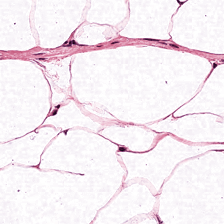

In [ ]:
tissue_tile_imgs_norm[100]

# Predict cancer regions with pre-trained model (CPU only) 

In [ ]:
model.input_shape

(None, 224, 224, 3)

In [ ]:
# test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# # test_generator = test_datagen.flow_from_directory(TEST_INPUT_PATH,
# #                                                       classes=['cancer', 'non-cancer'],
# #                                                       target_size= (224, 224, 3),
# #                                                       batch_size=1,
# #                                                       class_mode='binary',
# #                                                       shuffle=False)
# test_datagen.fit([np.array(img) for img in tissue_tile_imgs_norm])

In [ ]:
predictions = []
for i in range(len(tissue_tile_imgs_norm)):
    predictions.append(model.predict(np.expand_dims(np.array(tissue_tile_imgs_norm[i])/ 255, axis = 0))[0][0])

In [ ]:
predictions

In [ ]:
tile_predictions = [(x, y, z) for (x, y), z in zip(tissue_tile_coords, predictions)]

In [ ]:
def plot_predictions(img, tile_predictions, tile_size):
    img_overlay = img.copy()
    d = ImageDraw.Draw(img_overlay)
    width = int(np.round(tile_size * 0.07))
    for row, column, prediction in tile_predictions:
        x_top_left, y_top_left = np.round(column * tile_size), np.round(row * tile_size)
        x_bottom_right, y_bottom_right = np.round(x_top_left + tile_size), np.round(y_top_left + tile_size)
        if prediction >= 0.5:
            outline = 'lime'
        elif prediction < 0.5:
            outline = 'red'
        d.rectangle([(x_top_left, y_top_left), (x_bottom_right, y_bottom_right)], outline = outline, width = width)
    return img_overlay        

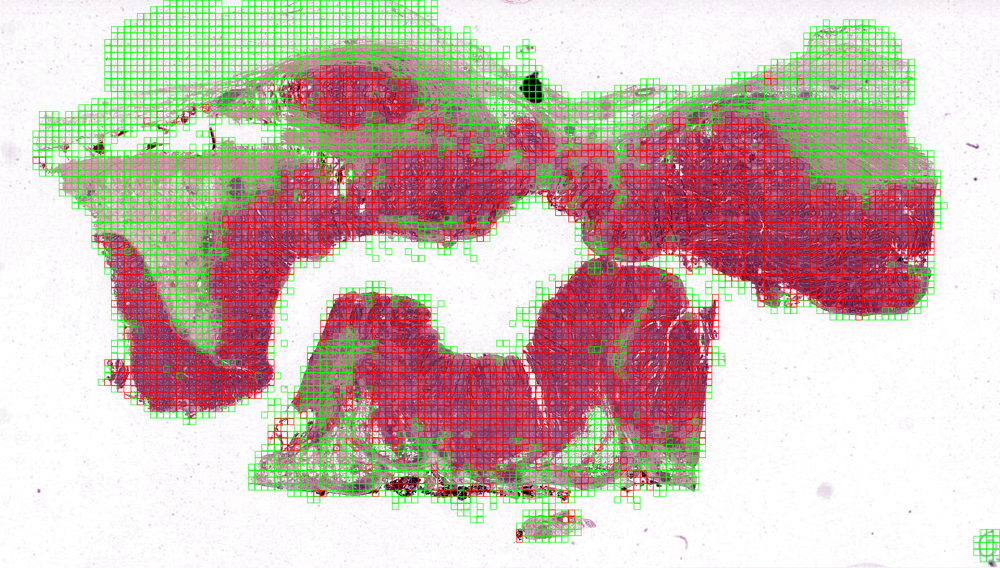

In [ ]:
predictions_overlay = plot_predictions(he_norm, tile_predictions, tile_size)
verbose_save_img(predictions_overlay, OUTPUT_PATH.joinpath(f'{PREFIX}_predictions.jpeg'), 'JPEG')
thumbnail(predictions_overlay)

In [ ]:
cancer_tiles = np.count_nonzero(np.array(predictions) < 0.5)
cancer_tile_proportion =  cancer_tiles / len(predictions)
slide_info['Cancer_Tiles'] = cancer_tiles
slide_info['Cancer_Tile_Proportion'] = cancer_tile_proportion
verbose_print(f'{cancer_tile_proportion * 100 :.2f}% of tissue tiles were predicted as cancer')

In [ ]:
# Create an array of tile predictions such that cancer = 1 and non-cancer = 0
tile_predictions_array = np.zeros(hist_proportion.shape)
for row, column, prediction in tile_predictions:
    tile_predictions_array[row, column] = 1 - prediction

In [ ]:
average_sigmoid_value = np.mean(1 - np.array(predictions))
slide_info['Average_Sigmoid_Value'] = average_sigmoid_value
average_sigmoid_value

0.47867128

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


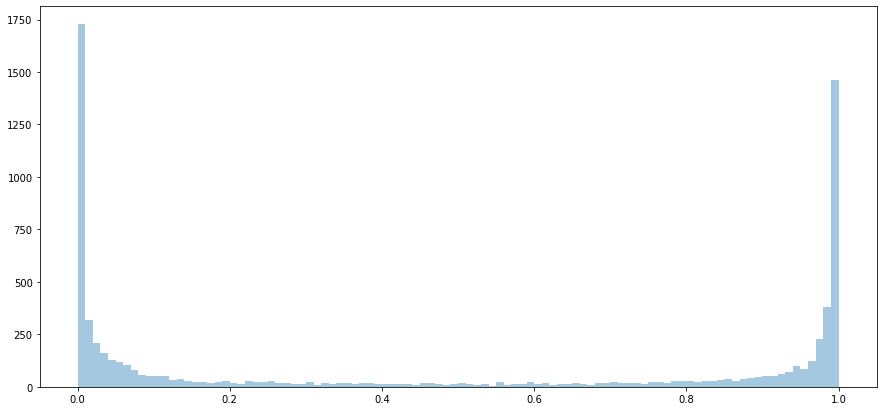

In [ ]:
figure = plt.figure(figsize = (15, 7))
sns.distplot(1 - np.array(predictions), kde = False, bins = 100)

In [ ]:
hist_proportion_norm = hist_proportion / hist_proportion.sum()
weighted_average_sigmoid_value = np.sum(tile_predictions_array * hist_proportion_norm)
slide_info['Weighted_Average_Sigmoid_Value'] = weighted_average_sigmoid_value
weighted_average_sigmoid_value

0.550297096675608

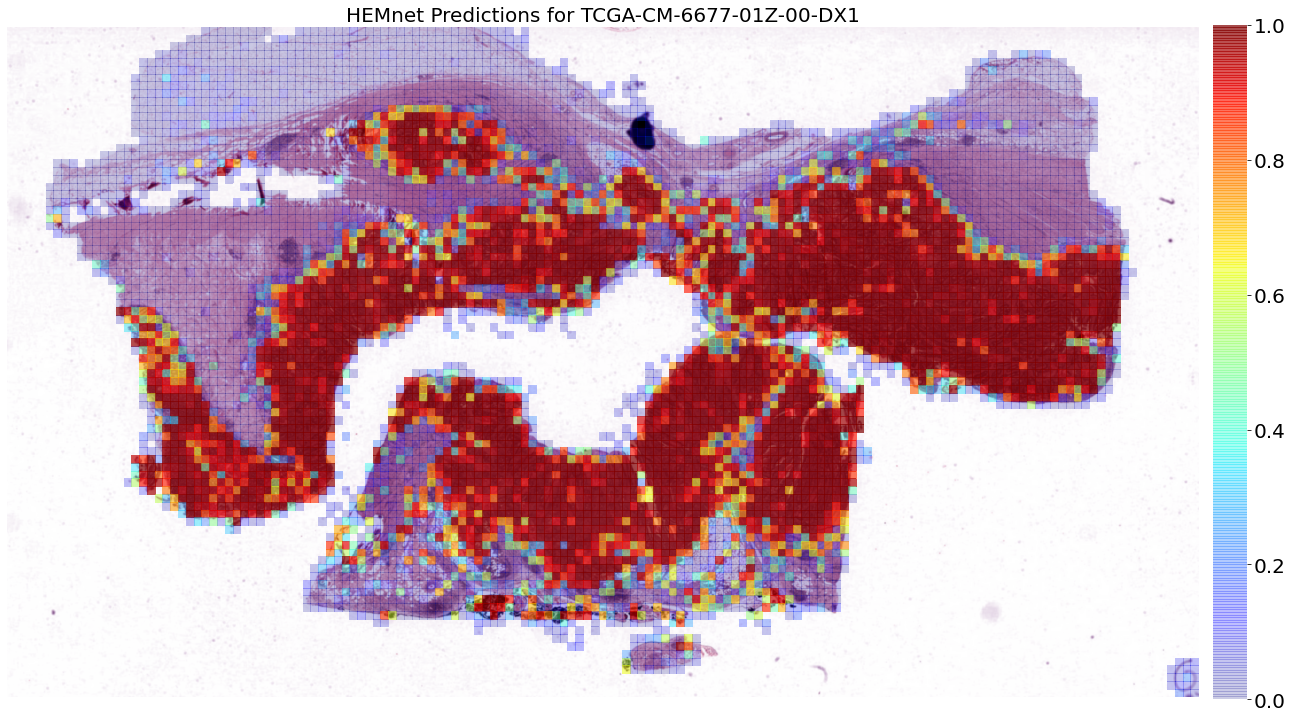

In [ ]:
# Overlay raw predictions heatmap over H&E tissue mask
predictions_heatmap = plt.figure(figsize = (20,10))
hmax = sns.heatmap(tile_predictions_array, vmin = 0, vmax = 1, square = True, xticklabels = False, yticklabels = False,
                   cmap = my_cmap, mask = (hist_proportion == 0),
                   cbar_kws = {'pad': 0.01})
cbar_axes =  hmax.figure.axes[-1]
cbar_axes.tick_params(labelsize = 20)
hmax.imshow(np.array(he_norm_cropped), 
            cmap = 'gray', 
            aspect = hmax.get_aspect(),
            extent = hmax.get_xlim() + hmax.get_ylim(),
            interpolation = 'bicubic',
            zorder = 0)
hmax.set_title(f'HEMnet Predictions for {SAMPLE_NAME}', fontsize = 20)
predictions_heatmap.tight_layout()
verbose_save_fig(predictions_heatmap, OUTPUT_PATH.joinpath(f'{SAMPLE_NAME}_predictions_heatmap.jpeg'))

In [ ]:
cancer_tile_array = tile_predictions_array >= 0.5

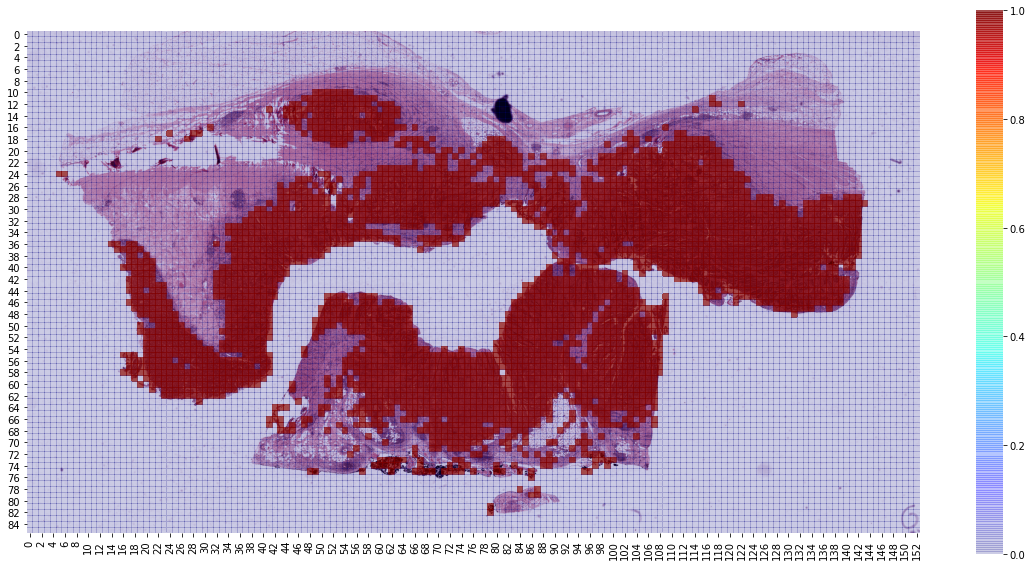

In [ ]:
fig = plt.figure(figsize = (20,10))
hmax = sns.heatmap(cancer_tile_array, vmin = 0, vmax = 1, square = True, 
                   cmap = my_cmap, linewidths = 0, linecolor = (0, 0, 0, 0))
hmax.imshow(he_norm_cropped, 
            cmap = 'gray', 
            aspect = hmax.get_aspect(),
            extent = hmax.get_xlim() + hmax.get_ylim(),
            zorder = 0)

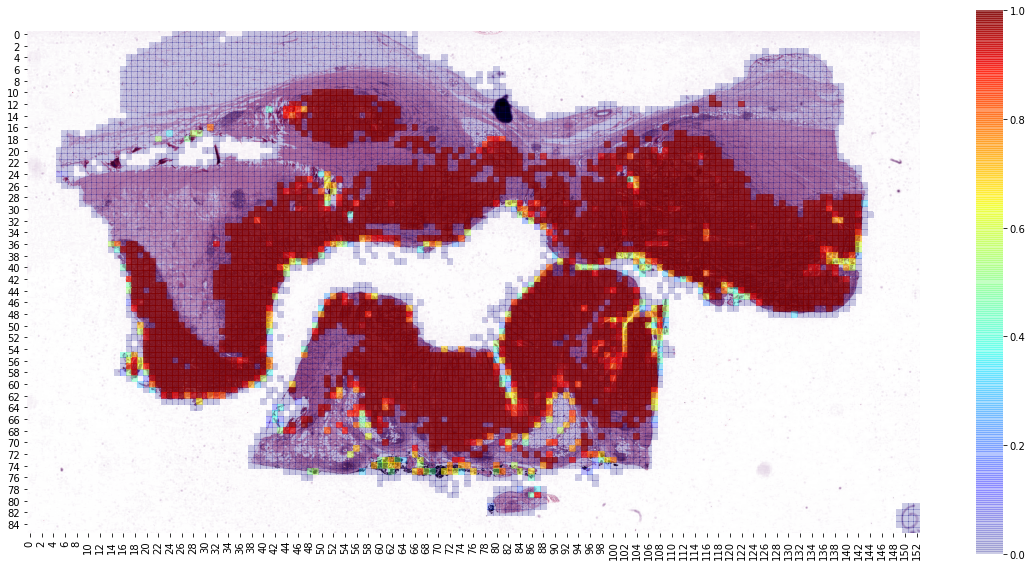

In [ ]:
cancer_tissue_area_array = cancer_tile_array * hist_proportion
fig = plt.figure(figsize = (20,10))
hmax = sns.heatmap(cancer_tissue_area_array, vmin = 0, vmax = 1, square = True, 
                   cmap = my_cmap, linewidths = 0, linecolor = (0, 0, 0, 0), mask = hist_proportion == 0)
hmax.imshow(he_norm_cropped, 
            cmap = 'gray', 
            aspect = hmax.get_aspect(),
            extent = hmax.get_xlim() + hmax.get_ylim(),
            zorder = 0)

In [ ]:
cancer_area_proportion = np.sum(cancer_tissue_area_array)/ np.sum(hist_proportion)
slide_info['Cancer_Area_Proportion'] = cancer_area_proportion
verbose_print(f'{cancer_area_proportion * 100 :.2f}% of tissue area was predicted as cancer')

In [ ]:
slide_info

{'Average_Sigmoid_Value': 0.47867128,
 'Cancer_Area_Proportion': 0.5571353518626699,
 'Cancer_Tile_Proportion': 0.47814018043025674,
 'Cancer_Tiles': 3445,
 'Sample_Name': 'TCGA-CM-6677-01Z-00-DX1',
 'Slide_Name': 'TCGA-CM-6677-01Z-00-DX1.e3428c0a-a194-4e38-b105-8244701fcc71.svs',
 'Tiles': 7205,
 'Weighted_Average_Sigmoid_Value': 0.550297096675608}

In [ ]:
list(slide_info.keys())

['Slide_Name',
 'Sample_Name',
 'Tiles',
 'Cancer_Tiles',
 'Cancer_Tile_Proportion',
 'Average_Sigmoid_Value',
 'Weighted_Average_Sigmoid_Value',
 'Cancer_Area_Proportion']

In [ ]:
# list(slide_info.keys())

In [ ]:
slide_info_series = pd.Series(slide_info, name = SAMPLE_NAME)
slide_info_series2 = pd.Series(slide_info, name = 'SAMPLE_NAME')

In [ ]:
slide_info_series

Slide_Name                        TCGA-CM-6677-01Z-00-DX1.e3428c0a-a194-4e38-b10...
Sample_Name                                                 TCGA-CM-6677-01Z-00-DX1
Tiles                                                                          7205
Cancer_Tiles                                                                   3445
Cancer_Tile_Proportion                                                      0.47814
Average_Sigmoid_Value                                                      0.478671
Weighted_Average_Sigmoid_Value                                             0.550297
Cancer_Area_Proportion                                                     0.557135
Name: TCGA-CM-6677-01Z-00-DX1, dtype: object

In [ ]:
slide_info_df.append(slide_info_series2)
# slide_info_df.append(slide_info, index = [2], sort = False)
#slide_info_df = slide_info_df[list(slide_info.keys())]

NameError: ignored

In [ ]:
slide_info_df.append()

In [ ]:
HEMnet = HEMnetModel(cnn_base=CNN_BASE, num_gpus= 0)
input_size = (HEMnet.get_input_shape()[0], HEMnet.get_input_shape()[1])

# test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_directory(TEST_INPUT_PATH,
#                                                   classes=['cancer', 'non-cancer'],
#                                                   target_size=input_size,
#                                                   batch_size=1,
#                                                   class_mode='binary',
#                                                   shuffle=False)

# HEMnet.load_model(MODEL_PATH)
# HEMnet.predict(test_generator)

In [ ]:
HEMnet.summary